In [15]:
##############################################################################
# 1. IMPORTAÇÃO DE BIBLIOTECAS
##############################################################################
import numpy as np
import random
# import gym
import matplotlib.pyplot as plt

# Se preferir, utilize "gymnasium" ao invés de "gym":
import gymnasium as gym

from collections import deque

# Para a versão Deep Q-Learning
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [16]:
##############################################################################
# 2. IMPLEMENTAÇÃO DO AGENTE Q-LEARNING
##############################################################################

class QLearningAgent:
    """
    Agente que utiliza Q-Learning com discretização para o MountainCar-v0.
    """
    def __init__(
        self,
        env,
        episodes=500,
        alpha=0.1,
        gamma=0.99,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.995,
        buckets=(19, 15),   # número de "subdivisões" (bins) para cada dimensão do estado
        discrete_bounds=None
    ):
        self.env = env
        self.episodes = episodes
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        
        # buckets define quantos 'intervalos' temos para cada dimensão do estado
        # ex.: (19,15) para MountainCar (posição e velocidade)
        self.buckets = buckets
        
        # Definimos limites de discretização para o estado
        # Por padrão, vamos usar o high/low do ambiente MountainCar:
        if discrete_bounds is None:
            # limites [pos_min, vel_min], [pos_max, vel_max]
            self.discrete_bounds = list(zip(self.env.observation_space.low, self.env.observation_space.high))
        else:
            self.discrete_bounds = discrete_bounds
        
        # Cria a Q-table com dimensões [pos_buckets, vel_buckets, n_actions]
        self.q_table = np.zeros(self.buckets + (self.env.action_space.n,))
        
    def discretize_state(self, state):
        """
        Converte o estado contínuo em índices discretos para indexar a Q-table.
        state: [pos, vel]
        """
        discretized = []
        for i in range(len(state)):
            # mapeia o valor state[i] para o índice da "bucket"
            low, high = self.discrete_bounds[i]
            # calcula a proporção do valor dentro do range
            ratio = (state[i] - low) / (high - low)
            # mapeia para o número de buckets
            new_obs = int(round((self.buckets[i] - 1) * ratio))
            # limita para [0, buckets[i]-1]
            new_obs = min(self.buckets[i] - 1, max(0, new_obs))
            discretized.append(new_obs)
        return tuple(discretized)
    
    def choose_action(self, state_idx):
        """
        Escolhe ação usando epsilon-greedy, dada a Q-table e o estado discretizado.
        """
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.q_table[state_idx])
    
    def train(self):
        """
        Executa o loop de treinamento do agente Q-Learning.
        Retorna um array com a recompensa total de cada episódio.
        """
        rewards_per_episode = []
        
        for ep in range(self.episodes):
            state, _ = self.env.reset()
            state_idx = self.discretize_state(state)
            
            done = False
            total_reward = 0
            
            while not done:
                action = self.choose_action(state_idx)
                next_state, reward, done, _, _ = self.env.step(action)
                
                # Penalidade extra se quiser acelerar aprendizado (opcional)
                # reward -= 1
                
                next_state_idx = self.discretize_state(next_state)
                
                # Atualização da Q-table
                old_value = self.q_table[state_idx + (action,)]
                future_estimate = np.max(self.q_table[next_state_idx])
                new_value = old_value + self.alpha * (reward + self.gamma * future_estimate - old_value)
                self.q_table[state_idx + (action,)] = new_value
                
                state_idx = next_state_idx
                total_reward += reward
            
            # Decay do epsilon
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            
            rewards_per_episode.append(total_reward)
        
        return rewards_per_episode

    def save_q_table(self, filename='q_table_mountaincar.csv'):
        """
        Salva a Q-table em arquivo CSV.
        """
        # A Q-table é 3D. Podemos salvar flatten, por exemplo.
        np.savetxt(filename, self.q_table.reshape(-1, self.env.action_space.n), delimiter=",")
    
    def load_q_table(self, filename='q_table_mountaincar.csv'):
        """
        Carrega a Q-table de arquivo CSV.
        """
        loaded = np.loadtxt(filename, delimiter=",")
        self.q_table = loaded.reshape(self.buckets + (self.env.action_space.n,))
    
    def evaluate(self, n_episodes=5, render=False):
        """
        Executa o agente utilizando a Q-table aprendida, sem exploração (epsilon=0).
        Retorna a média da recompensa sobre n_episodes.
        """
        old_epsilon = self.epsilon
        self.epsilon = 0.0  # Sem exploração para avaliação
        
        total_rewards = []
        
        for _ in range(n_episodes):
            state, _ = self.env.reset()
            state_idx = self.discretize_state(state)
            done = False
            episode_reward = 0
            
            while not done:
                if render:
                    self.env.render()
                action = np.argmax(self.q_table[state_idx])
                next_state, reward, done, _, _ = self.env.step(action)
                state_idx = self.discretize_state(next_state)
                episode_reward += reward
            
            total_rewards.append(episode_reward)
        
        self.epsilon = old_epsilon
        return np.mean(total_rewards), np.std(total_rewards)

In [17]:
##############################################################################
# 3. TREINAMENTO E ANÁLISE DE RESULTADOS DO Q-LEARNING
##############################################################################

def train_qlearning_runs(env, runs=5, episodes=500):
    """
    Realiza 'runs' treinamentos independentes do Q-Learning e coleta os resultados.
    Retorna uma lista de listas (episódios x run).
    """
    alpha = 0.1
    gamma = 0.99
    epsilon = 1.0
    epsilon_min = 0.01
    epsilon_decay = 0.995
    
    all_runs_rewards = []
    
    for r in range(runs):
        agent = QLearningAgent(
            env,
            episodes=episodes,
            alpha=alpha,
            gamma=gamma,
            epsilon=epsilon,
            epsilon_min=epsilon_min,
            epsilon_decay=epsilon_decay,
            buckets=(19, 15)
        )
        rewards = agent.train()
        all_runs_rewards.append(rewards)
        
        # Salva a Q-table do último run como exemplo
        agent.save_q_table(f"q_table_mountaincar_run_{r+1}.csv")
        
    return all_runs_rewards

def plot_learning_curves(all_runs_rewards, title="Q-Learning MountainCar"):
    """
    Dado uma lista de listas de recompensas de treinamento, plota a média e o intervalo.
    """
    arr = np.array(all_runs_rewards)  # shape: [runs, episodes]
    mean_ = np.mean(arr, axis=0)
    std_ = np.std(arr, axis=0)
    
    plt.figure()
    plt.title(title)
    plt.xlabel("Episódios")
    plt.ylabel("Recompensa")
    
    plt.plot(mean_, label="Recompensa média por episódio")
    plt.fill_between(range(len(mean_)), mean_ - std_, mean_ + std_, alpha=0.3, label="Desvio padrão")
    plt.legend()
    plt.show()


In [18]:
##############################################################################
# 4. IMPLEMENTAÇÃO DO AGENTE DEEP Q-LEARNING
##############################################################################

class DQNAgent:
    """
    Agente que utiliza Deep Q-Learning (rede neural) para o MountainCar-v0.
    """
    def __init__(
        self,
        env,
        episodes=500,
        gamma=0.99,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.995,
        lr=0.001,
        batch_size=64,
        max_memory_size=10000
    ):
        self.env = env
        self.episodes = episodes
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.lr = lr
        self.batch_size = batch_size
        
        # Memória (replay buffer) para experience replay
        self.memory = deque(maxlen=max_memory_size)
        
        # Cria modelo
        self.model = self.build_model()
        
    def build_model(self):
        # Observação: no MountainCar-v0 state.shape = (2,)
        # Precisamos de 2 entradas (posição e velocidade) e 3 ações possíveis
        model = Sequential()
        model.add(Dense(32, input_dim=self.env.observation_space.shape[0], activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.env.action_space.n, activation='linear'))
        
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.lr))
        return model

    def select_action(self, state):
        """
        Epsilon-greedy, mas agora o 'estado' é contínuo e será entrada da rede.
        """
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])
    
    def store_experience(self, state, action, reward, next_state, done):
        """
        Salva a transição (experiência) no replay buffer.
        """
        self.memory.append((state, action, reward, next_state, done))
    
    def replay_experience(self):
        """
        Executa o treinamento da rede neural com base em um batch amostrado
        aleatoriamente do replay buffer.
        """
        if len(self.memory) < self.batch_size:
            return
        
        batch = random.sample(self.memory, self.batch_size)
        
        states = []
        targets = []
        
        for state, action, reward, next_state, done in batch:
            q_update = reward
            if not done:
                q_next = np.max(self.model.predict(next_state, verbose=0)[0])
                q_update = reward + self.gamma * q_next
            
            q_values = self.model.predict(state, verbose=0)[0]
            q_values[action] = q_update
            
            states.append(state[0])   # state é (1,2), então pegamos state[0] = (2,)
            targets.append(q_values)  # q_values é (3,)
        
        states = np.array(states)
        targets = np.array(targets)
        
        self.model.fit(states, targets, epochs=1, verbose=0)
        
        # Ajusta epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def train(self):
        """
        Loop principal de treinamento.
        Retorna lista de recompensas por episódio.
        """
        rewards_per_episode = []
        
        for ep in range(self.episodes):
            state, _ = self.env.reset()
            state = np.reshape(state, (1, self.env.observation_space.shape[0]))  # shape (1,2)
            
            done = False
            total_reward = 0
            
            while not done:
                action = self.select_action(state)
                next_state, reward, done, _, _ = self.env.step(action)
                
                # reshape do next_state para servir de input na rede
                next_state = np.reshape(next_state, (1, self.env.observation_space.shape[0]))
                
                self.store_experience(state, action, reward, next_state, done)
                
                state = next_state
                total_reward += reward
                
                # Treina (experience replay)
                self.replay_experience()
            
            rewards_per_episode.append(total_reward)
            print(f"EP: {ep+1}/{self.episodes} | Reward: {total_reward:.2f} | Epsilon: {self.epsilon:.2f}")
        
        return rewards_per_episode
    
    def save_model(self, filename="dqn_mountaincar.h5"):
        self.model.save(filename)
    
    def load_model(self, filename="dqn_mountaincar.h5"):
        self.model = tf.keras.models.load_model(filename)
    
    def evaluate(self, n_episodes=5, render=False):
        """
        Executa o agente no modo de inferência (epsilon=0) e retorna média da recompensa.
        """
        old_epsilon = self.epsilon
        self.epsilon = 0.0
        
        total_rewards = []
        
        for _ in range(n_episodes):
            state, _ = self.env.reset()
            state = np.reshape(state, (1, self.env.observation_space.shape[0]))
            done = False
            episode_reward = 0
            
            while not done:
                if render:
                    self.env.render()
                q_values = self.model.predict(state, verbose=0)[0]
                action = np.argmax(q_values)
                
                next_state, reward, done, _, _ = self.env.step(action)
                next_state = np.reshape(next_state, (1, self.env.observation_space.shape[0]))
                state = next_state
                episode_reward += reward
                
            total_rewards.append(episode_reward)
        
        self.epsilon = old_epsilon
        return np.mean(total_rewards), np.std(total_rewards)

In [19]:
##############################################################################
# 5. TREINAMENTO E ANÁLISE DE RESULTADOS DO DEEP Q-LEARNING
##############################################################################

def train_dqn_runs(env, runs=5, episodes=500):
    """
    Realiza 'runs' treinamentos independentes do DQN e coleta os resultados.
    Retorna uma lista de listas com recompensas por episódio.
    """
    gamma = 0.99
    epsilon = 1.0
    epsilon_min = 0.01
    epsilon_decay = 0.995
    lr = 0.001
    batch_size = 64
    
    all_runs_rewards = []
    
    for r in range(runs):
        agent = DQNAgent(
            env,
            episodes=episodes,
            gamma=gamma,
            epsilon=epsilon,
            epsilon_min=epsilon_min,
            epsilon_decay=epsilon_decay,
            lr=lr,
            batch_size=batch_size
        )
        rewards = agent.train()
        all_runs_rewards.append(rewards)
        
        # Salvar o modelo
        agent.save_model(f"dqn_mountaincar_run_{r+1}.h5")
    
    return all_runs_rewards

def plot_learning_curves_dqn(all_runs_rewards, title="Deep Q-Learning MountainCar"):
    """
    Plota curva de aprendizado para o DQN.
    """
    arr = np.array(all_runs_rewards)  # shape: [runs, episodes]
    mean_ = np.mean(arr, axis=0)
    std_ = np.std(arr, axis=0)
    
    plt.figure()
    plt.title(title)
    plt.xlabel("Episódios")
    plt.ylabel("Recompensa")
    
    plt.plot(mean_, label="Recompensa média por episódio")
    plt.fill_between(range(len(mean_)), mean_ - std_, mean_ + std_, alpha=0.3, label="Desvio padrão")
    plt.legend()
    plt.show()

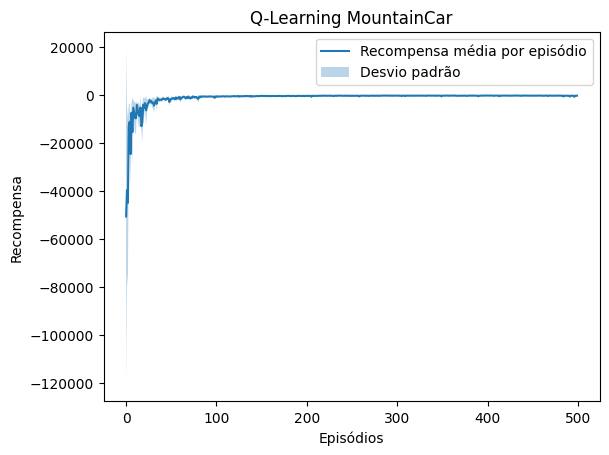

c:\Users\bbsab\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
##############################################################################
# 6. COMPARAÇÃO DAS CURVAS DE APRENDIZADO
##############################################################################

# Aqui podemos chamar as funções de treinamento para Q-Learning e DQN e comparar.

if __name__ == "__main__":
    # Cria ambiente
    env = gym.make("MountainCar-v0")
    
    # 6.1. Executa Q-Learning em 'runs' diferentes
    ql_runs = 5
    ql_episodes = 500
    qlearning_all_runs = train_qlearning_runs(env, runs=ql_runs, episodes=ql_episodes)
    plot_learning_curves(qlearning_all_runs, title="Q-Learning MountainCar")

    # 6.2. Executa DQN em 'runs' diferentes
    dqn_runs = 5
    dqn_episodes = 500
    dqn_all_runs = train_dqn_runs(env, runs=dqn_runs, episodes=dqn_episodes)
    plot_learning_curves_dqn(dqn_all_runs, title="Deep Q-Learning MountainCar")
    
    # Podemos comparar visualmente (se quiser em um único gráfico):
    plt.figure()
    plt.title("Comparação Q-Learning vs DQN (MountainCar)")
    plt.xlabel("Episódios")
    plt.ylabel("Recompensa")
    
    # Q-Learning
    q_arr = np.array(qlearning_all_runs)
    q_mean = np.mean(q_arr, axis=0)
    plt.plot(q_mean, label="Q-Learning")
    
    # DQN
    d_arr = np.array(dqn_all_runs)
    d_mean = np.mean(d_arr, axis=0)
    plt.plot(d_mean, label="DQN")
    
    plt.legend()
    plt.show()

In [ ]:
##############################################################################
# 7. AVALIAÇÃO (INFERÊNCIA) E COMPARAÇÃO DE DESEMPENHO
##############################################################################

    # Exemplo de avaliação de 1 run Q-Learning:
    agent_ql = QLearningAgent(env)
    # Carrega a Q-table de um dos treinos salvos (exemplo do primeiro run).
    agent_ql.load_q_table("q_table_mountaincar_run_1.csv")
    mean_reward_ql, std_reward_ql = agent_ql.evaluate(n_episodes=10, render=False)
    print(f"[Q-Learning] Avaliação em 10 episódios -> Média de recompensa: {mean_reward_ql:.2f}, Desvio-padrão: {std_reward_ql:.2f}")
    
    # Exemplo de avaliação de 1 run DQN:
    agent_dqn = DQNAgent(env)
    # Carrega o modelo salvo (exemplo do primeiro run).
    agent_dqn.load_model("dqn_mountaincar_run_1.h5")
    mean_reward_dqn, std_reward_dqn = agent_dqn.evaluate(n_episodes=10, render=False)
    print(f"[DQN] Avaliação em 10 episódios -> Média de recompensa: {mean_reward_dqn:.2f}, Desvio-padrão: {std_reward_dqn:.2f}")